In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

from keras.layers import Input, Dense
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython.display import display, clear_output

from PIL import Image, ImageSequence

In [4]:
!nvidia-smi -L # list GPUs available

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-1b733ae9-677b-c89f-b618-62b480a8af0b)


In [3]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [3]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [4]:
x_vals_all

array([[-1.08511704, -0.13951411,  0.29623825, -1.38625319,  0.5       ,
         0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, -1.20087092,  0.5       ,
         0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, -0.51460752,  0.5       ,
         0.5       ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [5]:
m1_list = np.unique(x_vals_all[:, -2])
m2_list = np.unique(x_vals_all[:, -1])

In [7]:
model_all_BCE = tf.keras.models.load_model("models/model_all_BCE_3_4096")
#model_all_MSE = tf.keras.models.load_model("models/model_all_MSE_3_4096")

2023-11-13 21:07:19.706332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 21:07:20.870875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11925 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [29]:
#specific sigfrac
z = {}
losses_list = []
epsilon = 1e-6
for w1 in m1_list:
    for w2 in m2_list:
        sigfrac = 0.05

        for l in model_all_MSE.layers:
            l.trainable=False

        model3 = createSimpleModel(w1)
        model32 = createSimpleModel(w2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all_MSE(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1 + sigfrac*LLR - sigfrac
        #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
        ws = LLR_xs / (1.+ LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss=tf.keras.losses.Binarycrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.9))

        m1 = 3.5
        m2 = 4

        test_background = int(1/2 *len(x[0,0]))
        train_background = int(1/4 * len(x[0,0]))
        train_data = int(1/4 * len(x[0,0]))
        train_reference = int(1/4 * len(x[0,0]))
        #signal
        test_signal_length = int(1/2*len(x[m1,m2]))
        N = int(1/4 * (len(x[0,0])))
        signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

        x_vals_ = np.concatenate([x[0,0][test_background:],signal])
        #[reference (0), data_background (1), signal(1)]
        y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
        #print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

        #myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])

        loss = model_all2.evaluate(x_vals_, y_vals_, verbose = 0)
        losses_list.append(loss)
z[sigfrac, m1, m2] = losses_list
#print(np.shape(losses_list))
losses_list = []

4 Features 2 Parameter Semi Weakly Supervised Model

In [ ]:
#varying sigfrac, fixed mass pair
z = {}
losses_list = []

epsilon = 1e-6

sig_space = np.logspace(-3, -1, 20)
for sig in sig_space:
    print("Signal Fraction: ", sig)
    #print(w1, w2)
    for w1 in m1_list:
        for w2 in m2_list:
            sigfrac = sig
    
            for l in model_all_BCE.layers:
                l.trainable=False

            model3 = createSimpleModel(w1)
            model32 = createSimpleModel(w2)

            inputs_hold3 = tf.keras.Input(shape=(1,))
            simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
            model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all_BCE(inputs2)
            LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
            LLR_xs = 1 + sigfrac*LLR - sigfrac
            #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
            ws = LLR_xs / (1.+ LLR_xs)
            model_all2 = Model(inputs = inputs, outputs = ws)
            model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            m1 = 1
            m2 = 5.5

            test_background = int(1/2 *len(x[0,0]))
            train_background = int(1/4 * len(x[0,0]))
            train_data = int(1/4 * len(x[0,0]))
            train_reference = int(1/4 * len(x[0,0]))
            #signal
            test_signal_length = int(1/2*len(x[m1,m2]))
            N = int(1/4 * (len(x[0,0])))
            signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

            x_vals_ = np.concatenate([x[0,0][test_background:],signal])
            #[reference (0), data_background (1), signal(1)]
            y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
            #print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

            #myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
            
            loss = model_all2.evaluate(x_vals_, y_vals_, verbose = 0)
            losses_list.append(loss)
    z[sigfrac, m1, m2] = losses_list
    #print(np.shape(losses_list))
    losses_list = []

Signal Fraction:  0.001
Signal Fraction:  0.0012742749857031334
Signal Fraction:  0.001623776739188721
Signal Fraction:  0.00206913808111479
Signal Fraction:  0.0026366508987303583
Signal Fraction:  0.003359818286283781
Signal Fraction:  0.004281332398719396
Signal Fraction:  0.00545559478116852
Signal Fraction:  0.0069519279617756054
Signal Fraction:  0.008858667904100823
Signal Fraction:  0.011288378916846888
Signal Fraction:  0.01438449888287663
Signal Fraction:  0.018329807108324356
Signal Fraction:  0.023357214690901212
Signal Fraction:  0.029763514416313176
Signal Fraction:  0.0379269019073225
Signal Fraction:  0.04832930238571752
Signal Fraction:  0.06158482110660261
Signal Fraction:  0.07847599703514611


In [641]:
#np.save("z_sig33.5MSE", z)

In [ ]:
sig_space

In [125]:
z.keys()

dict_keys([(0.001, 1, 5.5), (0.0012742749857031334, 1, 5.5), (0.001623776739188721, 1, 5.5), (0.00206913808111479, 1, 5.5), (0.0026366508987303583, 1, 5.5), (0.003359818286283781, 1, 5.5), (0.004281332398719396, 1, 5.5), (0.00545559478116852, 1, 5.5), (0.0069519279617756054, 1, 5.5), (0.008858667904100823, 1, 5.5), (0.011288378916846888, 1, 5.5), (0.01438449888287663, 1, 5.5), (0.018329807108324356, 1, 5.5), (0.023357214690901212, 1, 5.5), (0.029763514416313176, 1, 5.5), (0.0379269019073225, 1, 5.5), (0.04832930238571752, 1, 5.5), (0.06158482110660261, 1, 5.5), (0.07847599703514611, 1, 5.5)])

In [35]:
m1_values, m2_values = zip(*grid_axes.keys())

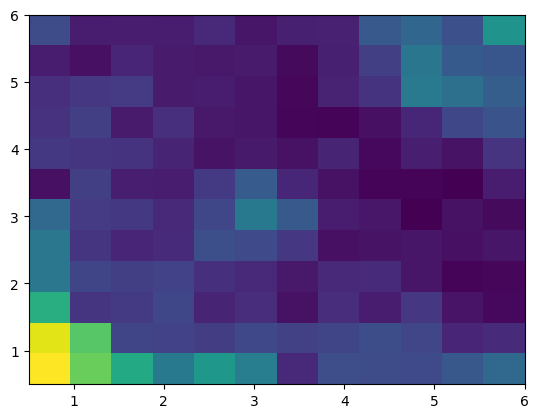

In [415]:
loss_values = list(z[sig_space[0], 1, 5.5])

plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=loss_values);

In [743]:
def loss_landscape_2D_notfit(m1, m2, w1_out, w2_out):
    m1_values, m2_values = zip(*z.keys())

    loss_values = list(z.values())
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    #fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
   # plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('2D Histogram of Losses (m1 = {}'.format(m1) + " | m2 = {})".format(m2))
    return h

loss_landscape_2D(3, 4.5, 6, 6);

In [606]:
z345 = np.load("z_sig34.5.npy", allow_pickle = True).item()

In [25]:
count = 0
for m1 in m1_list:
    for m2 in m2_list:
        if m2 >= m1:
            print(m1, m2)
        # if count == 15:
        #     break
        #print(m1, m2)
            count+=1

0.5 0.5
0.5 1.0
0.5 1.5
0.5 2.0
0.5 2.5
0.5 3.0
0.5 3.5
0.5 4.0
0.5 4.5
0.5 5.0
0.5 5.5
0.5 6.0
1.0 1.0
1.0 1.5
1.0 2.0
1.0 2.5
1.0 3.0
1.0 3.5
1.0 4.0
1.0 4.5
1.0 5.0
1.0 5.5
1.0 6.0
1.5 1.5
1.5 2.0
1.5 2.5
1.5 3.0
1.5 3.5
1.5 4.0
1.5 4.5
1.5 5.0
1.5 5.5
1.5 6.0
2.0 2.0
2.0 2.5
2.0 3.0
2.0 3.5
2.0 4.0
2.0 4.5
2.0 5.0
2.0 5.5
2.0 6.0
2.5 2.5
2.5 3.0
2.5 3.5
2.5 4.0
2.5 4.5
2.5 5.0
2.5 5.5
2.5 6.0
3.0 3.0
3.0 3.5
3.0 4.0
3.0 4.5
3.0 5.0
3.0 5.5
3.0 6.0
3.5 3.5
3.5 4.0
3.5 4.5
3.5 5.0
3.5 5.5
3.5 6.0
4.0 4.0
4.0 4.5
4.0 5.0
4.0 5.5
4.0 6.0
4.5 4.5
4.5 5.0
4.5 5.5
4.5 6.0
5.0 5.0
5.0 5.5
5.0 6.0
5.5 5.5
5.5 6.0
6.0 6.0


In [26]:
print(count)

78


In [340]:
z_allm1m2 = np.load("z_allsigm1m2.npy", allow_pickle = True).item()
losses = []

epsilon = 1e-6
sigfrac = 0.03
print("Signal Fraction: ", sigfrac)
for m1 in m1_list:
    for m2 in m2_list:
        if (sigfrac,m1,m2) not in z_allm1m2:
            print(w1, w2, m1, m2)
        for w1 in m1_list:
            for w2 in m2_list:
                
                for l in model_all_MSE.layers:
                    l.trainable=False

                model3 = createSimpleModel(w1)
                model32 = createSimpleModel(w2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(4,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model_all_MSE(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1 + sigfrac*LLR - sigfrac
                #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
                ws = LLR_xs / (1.+ LLR_xs)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                if (sigfrac,m1,m2) in z_allm1m2:
                    break

                test_background = int(1/2 *len(x[0,0]))
                train_background = int(1/4 * len(x[0,0]))
                train_data = int(1/4 * len(x[0,0]))
                train_reference = int(1/4 * len(x[0,0]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2]))
                N = int(1/4 * (len(x[0,0])))
                signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_vals_ = np.concatenate([x[0,0][test_background:],signal])
                #[reference (0), data_background (1), signal(1)]
                y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
                
                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

                # for epoch in range(20):
                #     myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, callbacks = [es])
                #     w1_out = model_all2.trainable_weights[0].numpy()[0][0]
                #     w2_out = model_all2.trainable_weights[1].numpy()[0][0]
                #     fit_out[epoch] = [w1_out, w2_out]
                
                with tf.device('/GPU:0'):
                    loss = model_all2.evaluate(x_vals_, y_vals_, verbose = 0)
                losses.append(loss)

        if (sigfrac,m1,m2) in z_allm1m2:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z_allm1m2[sigfrac,m1,m2] = losses
            losses = []
            np.save("z_allm1m2", z_allm1m2)

Signal Fraction:  0.05
Landscape for m1 = 0.5 and m2 = 0.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 1.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 1.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 2.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 2.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 3.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 3.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 4.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 4.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 5.0  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 5.5  already exists for 0.05 signal fraction
Landscape for m1 = 0.5 and m2 = 6.0  already exists for 0.05 signal fraction
Landscape for m1 = 1.0 and m2 = 0.5  already exists f

In [403]:
z_allm1m2.keys()

dict_keys([(0.05, 0.5, 0.5), (0.05, 0.5, 1.0), (0.05, 0.5, 1.5), (0.05, 0.5, 2.0), (0.05, 0.5, 2.5), (0.05, 0.5, 3.0), (0.05, 0.5, 3.5), (0.05, 0.5, 4.0), (0.05, 0.5, 4.5), (0.05, 0.5, 5.0), (0.05, 0.5, 5.5), (0.05, 0.5, 6.0), (0.05, 1.0, 0.5), (0.05, 1.0, 1.0), (0.05, 1.0, 1.5), (0.05, 1.0, 2.0), (0.05, 1.0, 2.5), (0.05, 1.0, 3.0), (0.05, 1.0, 3.5), (0.05, 1.0, 4.0), (0.05, 1.0, 4.5), (0.05, 1.0, 5.0), (0.05, 1.0, 5.5), (0.05, 1.0, 6.0), (0.05, 1.5, 0.5), (0.05, 1.5, 1.0), (0.05, 1.5, 1.5), (0.05, 1.5, 2.0), (0.05, 1.5, 2.5), (0.05, 1.5, 3.0), (0.05, 1.5, 3.5), (0.05, 1.5, 4.0), (0.05, 1.5, 4.5), (0.05, 1.5, 5.0), (0.05, 1.5, 5.5), (0.05, 1.5, 6.0), (0.05, 2.0, 0.5), (0.05, 2.0, 1.0), (0.05, 2.0, 1.5), (0.05, 2.0, 2.0), (0.05, 2.0, 2.5), (0.05, 2.0, 3.0), (0.05, 2.0, 3.5), (0.05, 2.0, 4.0), (0.05, 2.0, 4.5), (0.05, 2.0, 5.0), (0.05, 2.0, 5.5), (0.05, 2.0, 6.0), (0.05, 2.5, 0.5), (0.05, 2.5, 1.0), (0.05, 2.5, 1.5), (0.05, 2.5, 2.0), (0.05, 2.5, 2.5), (0.05, 2.5, 3.0), (0.05, 2.5, 3.5),

In [131]:
import random
grid_axes = {}
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        grid_axes[m1,m2] = random.randint(1, 10)

In [790]:
z345 = np.load("z_sig34.5MSE.npy", allow_pickle = True).item()

In [806]:
z345.keys()

dict_keys([(0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.0379269019073225, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5)])

In [142]:
def loss_landscape_2D(sigfrac, m1, m2, w1_out, w2_out, z):
    m1_values, m2_values = zip(*grid_axes.keys())

    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('(m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    return h

#loss_landscape_2D(list(sig_space)[3], 1.5, 4, 6, 6, z);

Final weight coordinates: w1 = 2.9546401500701904  w2 = 4.470359802246094 


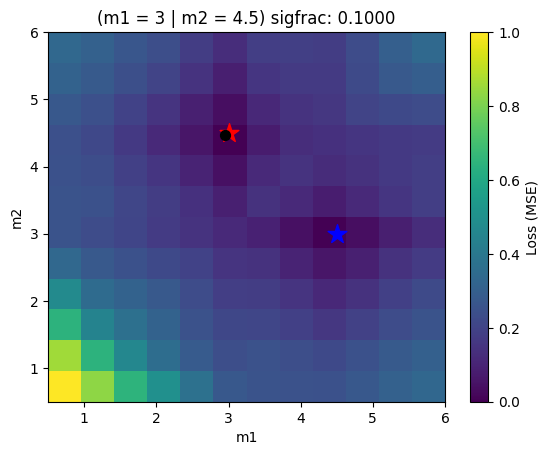

In [805]:
def animate(sigfrac, m1, m2, w1, w2, epochs, z, lr_schedule):
    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs, lr_schedule).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        plt.figure()
        loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)
        plt.show()
        clear_output(wait=True)
        
    loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)
    print("Final weight coordinates: w1 = {} ".format(w1_fit_coord) + " w2 = {} ".format(w2_fit_coord))
        
sigfrac = sig_list[19]
w1, w2 = 2, 3
m1, m2 = 3, 4.5
epochs = 50
animate(sigfrac, m1, m2, w1, w2, epochs, z345, lr_schedule)

Final weight coordinates: w1 = 0.997785210609436  w2 = 5.534912109375 


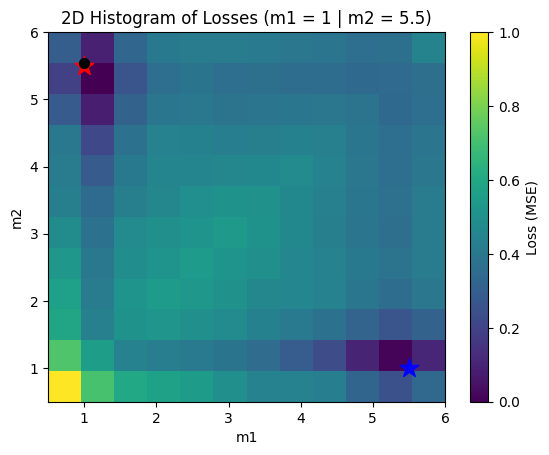

In [540]:
def animate_random(sigfrac, m1,m2, w1, w2, epochs):
    print(f"Initial Weights: {w1} {w2}")
    animate(sigfrac, m1, m2, w1, w2, epochs)
    
sigfrac = 0.05
random_number1 = random.uniform(0.1, 6.0)
random_number2 = random.uniform(0.1, 6.0)
m1, m2 = 1, 5.5
epochs = 50

animate_random(sigfrac, m1,m2, random_number1, random_number2, 50)

In [631]:
#save images to make them gifs
def create_gif_fitout(sigfrac, m1, m2, w1, w2, z):
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)

    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)

        image_path = os.path.join(output_directory, f'hist_{key}.png')
        plt.savefig(image_path)
        plt.close()

        clear_output(wait=True)

    #make the gif
    frames = []

    image_dir = '2dhist_images'
    image_files = os.listdir(image_dir)

    image_files = sorted([filename for filename in os.listdir(image_dir) if filename.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
    for filename in image_files:
        image = Image.open(os.path.join(image_dir, filename))
        frames.append(image)
        os.remove(image_dir+"/"+filename)

    output_gif_filename = f'{sigfrac, m1, m2, w1, w2}.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=200, loop=0)

In [139]:
def train_wsmodel(sigfrac, m1, m2, w1, w2, epochs, lr_schedule):

    sig_list = []
    w1_list = []
    w2_list = []

    fit_out = {}

    epsilon = 1e-6

    sigfrac = sigfrac
    print("Signal Fraction: ", sigfrac)
    for l in model_all_BCE.layers:
        l.trainable=False

    model3 = createSimpleModel(w1)
    model32 = createSimpleModel(w2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_BCE(inputs2)
    LLR = hidden_layer_1 / (1.- hidden_layer_1 + epsilon)
    LLR_xs = 1 + sigfrac * LLR - sigfrac
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
    ws = (LLR_xs / (1.+ LLR_xs))
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

    m1 = m1
    m2 = m2

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (0), data_background (1), signal(1)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    with tf.device('/GPU:0'):
        for epoch in range(epochs):
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=1,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            w1_out = model_all2.trainable_weights[0].numpy()[0][0]
            w2_out = model_all2.trainable_weights[1].numpy()[0][0]
            fit_out[epoch] = [w1_out, w2_out]

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    
    return fit_out

In [143]:
initial_learning_rate = 0.05 #placeholder till callback

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
)
    
def create_gif_nofit(sigfrac, m1, m2, w1, w2, z):
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    frames = []  # List to store frames for all sigfrac values

    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs, lr_schedule).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

    loss_landscape_2D(sigfrac, m1, m2, 0, 0, z)

    image_path = os.path.join(output_directory, f'hist_{key}.png')
    plt.savefig(image_path)
    plt.close()
    clear_output(wait=True)

    # Append the image to the frames list
    frames.append(Image.open(image_path))

    return frames

# Loop through different sigfrac values and collect frames
all_frames = []
sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space[:-1]:
    # w1 = random.uniform(0.1, 6.0)
    # w2 = random.uniform(0.1, 6.0)
    m1, m2 = 1, 5.5
    epochs = 35
    frames = create_gif_nofit(sigfrac, m1, m2, w1, w2, z)
    all_frames.extend(frames)

# Create the final GIF that combines all frames
output_gif_filename = 'sigspace15.5.gif'
all_frames[0].save(output_gif_filename, save_all=True, append_images=all_frames[1:], duration=400, loop=0)

Signal Fraction:  0.07847599703514611
31/31 [==============================] - 0s 7ms/step - loss: 0.2470 - val_loss: 0.2470
1 5.5 5.612639 5.369765


In [645]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

w1: 5.705 w2: 3.198
Signal Fraction:  0.001
Epoch 1/35
30/30 [==============================] - 1s 13ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 2/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 6/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 

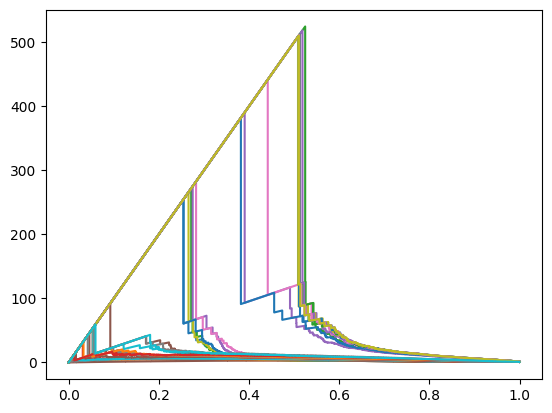

In [19]:
from models import createSimpleModel
sig_list = []
w1_list = []
w2_list = []
w3_list = []

max_SIC1 = []
max_SIC2 = []

epsilon = 1e-6

#random_test_signal_length = random.randint(0, test_signal_length - 1)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
initial_learning_rate = 0.05 #placeholder till callback

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
)

sig_space = np.logspace(-3, -1, 20)
w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)

print(f"w1: {w1} w2: {w2}")
for sigfrac in sig_space:
    print("Signal Fraction: ", sigfrac)
    for l in model_all_BCE.layers:
        l.trainable=False
    
    model3 = createSimpleModel(w1)
    model32 = createSimpleModel(w2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_BCE(inputs2)
    LLR = hidden_layer_1 / (1.- hidden_layer_1 + epsilon)
    LLR_xs = 1 + sigfrac * LLR - sigfrac
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
    ws = (LLR_xs / (1.+ LLR_xs))
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

    m1 = 2
    m2 = 4.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],signal])
    #[reference (1), data_background (0), signal(0)]
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    sig_list+=[sigfrac]
    w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
    w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

    print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    #plt.plot(tpr,tpr/np.sqrt(fpr))
    #plt.plot(tpr,fpr)

    #CWOLA
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr + epsilon))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2 + epsilon))
    
    max_SIC1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
    max_SIC2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

2.084 4.771 0.001
30232 90698 30 0.0009923260121725325
Epoch 1/35
30/30 [==============================] - 1s 10ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 6/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 10/35
30/30 [==============================] - 0s 6ms/st

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 6/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 2/35
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 6/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 11/35
30/30 [=========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 4/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 5/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 6/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30232 90698 101 0.0033408309076475256
Epoch 1/35
30/30 [==============================] - 1s 14ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 14ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6926
Epoch 3/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 4/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 13ms/step - loss: 0.6928 - val_loss: 0.6925
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6927 - val_loss: 0.6925
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6927 - val_loss: 0.6925
Epoch 4/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6927 - val_loss: 0.6925
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6927 - val_loss: 0.6925
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6927 - val_loss: 0.6925
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 13ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 2/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 3/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6926 - val_loss: 0.6924
Epoch 4/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6924 - val_loss: 0.6922
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6924 - val_loss: 0.6922
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6921 - val_loss: 0.6921
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6920 - val_loss: 0.6923
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6921 - val_loss: 0.6922
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6920 - val_loss: 0.6922
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6920 - val_loss: 0.6922
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6920 - val_loss: 0.6922
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6920 - val_loss: 0.6922
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6920 - val_loss: 0.6922
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6920 - val_loss: 0.6922
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6920 - val_loss: 0.6922
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 13ms/step - loss: 0.6922 - val_loss: 0.6915
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6920 - val_loss: 0.6915
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6919 - val_loss: 0.6916
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6918 - val_loss: 0.6913
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6914 - val_loss: 0.6908
Epoch 6/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6912 - val_loss: 0.6907
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6912 - val_loss: 0.6907
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6912 - val_loss: 0.6907
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6911 - val_loss: 0.6907
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6911 - val_loss: 0.6907
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6918 - val_loss: 0.6911
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6918 - val_loss: 0.6911
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6917 - val_loss: 0.6911
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6917 - val_loss: 0.6911
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6917 - val_loss: 0.6912
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6917 - val_loss: 0.6911
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6917 - val_loss: 0.6912
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6917 - val_loss: 0.6911
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6916 - val_loss: 0.6910
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6915 - val_loss: 0.6908
Epoch 11/35
30/30 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/35
30/30 [==============================] - 1s 12ms/step - loss: 0.6911 - val_loss: 0.6907
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6905
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6907 - val_loss: 0.6891
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6898 - val_loss: 0.6894
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6895 - val_loss: 0.6890
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6894 - val_loss: 0.6889
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6894 - val_loss: 0.6889
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6894 - val_loss: 0.6889
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6895 - val_loss: 0.6890
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6894 - val_loss: 0.6890
Epoch 11/35
30/30 

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/35
30/30 [==============================] - 1s 12ms/step - loss: 0.6904 - val_loss: 0.6904
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6897 - val_loss: 0.6897
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6882 - val_loss: 0.6881
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6880 - val_loss: 0.6879
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6881 - val_loss: 0.6879
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6880 - val_loss: 0.6878
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6880 - val_loss: 0.6879
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6880 - val_loss: 0.6879
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6880 - val_loss: 0.6878
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6879 - val_loss: 0.6879
Epoch 11/35
30/30 

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 12ms/step - loss: 0.6902 - val_loss: 0.6906
Epoch 2/35
31/31 [==============================] - 0s 8ms/step - loss: 0.6902 - val_loss: 0.6904
Epoch 3/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6901 - val_loss: 0.6899
Epoch 4/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6896 - val_loss: 0.6895
Epoch 5/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6872 - val_loss: 0.6869
Epoch 6/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6859 - val_loss: 0.6867
Epoch 7/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6862 - val_loss: 0.6867
Epoch 8/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6861 - val_loss: 0.6868
Epoch 9/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6861 - val_loss: 0.6867
Epoch 10/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6860 - val_loss: 0.6867
Epoch 11/35
31/31 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 16ms/step - loss: 0.6893 - val_loss: 0.6868
Epoch 2/35
31/31 [==============================] - 0s 8ms/step - loss: 0.6883 - val_loss: 0.6865
Epoch 3/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6859 - val_loss: 0.6838
Epoch 4/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6850 - val_loss: 0.6836
Epoch 5/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6849 - val_loss: 0.6837
Epoch 6/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6849 - val_loss: 0.6836
Epoch 7/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6849 - val_loss: 0.6836
Epoch 8/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6849 - val_loss: 0.6836
Epoch 9/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6849 - val_loss: 0.6836
Epoch 10/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6849 - val_loss: 0.6836
Epoch 11/35
31/31 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 15ms/step - loss: 0.6885 - val_loss: 0.6878
Epoch 2/35
31/31 [==============================] - 0s 8ms/step - loss: 0.6850 - val_loss: 0.6819
Epoch 3/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6821 - val_loss: 0.6812
Epoch 4/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6822 - val_loss: 0.6811
Epoch 5/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6823 - val_loss: 0.6813
Epoch 6/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6820 - val_loss: 0.6811
Epoch 7/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6823 - val_loss: 0.6811
Epoch 8/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6821 - val_loss: 0.6811
Epoch 9/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6821 - val_loss: 0.6811
Epoch 10/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6822 - val_loss: 0.6811
Epoch 11/35
31/31 [==========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 12ms/step - loss: 0.6854 - val_loss: 0.6832
Epoch 2/35
31/31 [==============================] - 0s 12ms/step - loss: 0.6790 - val_loss: 0.6786
Epoch 3/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6781 - val_loss: 0.6784
Epoch 4/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6779 - val_loss: 0.6784
Epoch 5/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 6/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6780 - val_loss: 0.6785
Epoch 7/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6780 - val_loss: 0.6783
Epoch 8/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6782 - val_loss: 0.6784
Epoch 9/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6780 - val_loss: 0.6783
Epoch 10/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6779 - val_loss: 0.6783
Epoch 11/35
31/31 [=========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 11ms/step - loss: 0.6858 - val_loss: 0.6812
Epoch 2/35
31/31 [==============================] - 0s 10ms/step - loss: 0.6760 - val_loss: 0.6730
Epoch 3/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6750 - val_loss: 0.6729
Epoch 4/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6756 - val_loss: 0.6729
Epoch 5/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6751 - val_loss: 0.6729
Epoch 6/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6751 - val_loss: 0.6730
Epoch 7/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6751 - val_loss: 0.6729
Epoch 8/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6751 - val_loss: 0.6729
Epoch 9/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6750 - val_loss: 0.6729
Epoch 10/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6751 - val_loss: 0.6729
Epoch 11/35
31/31 [=========

/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_2071371/206957106.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


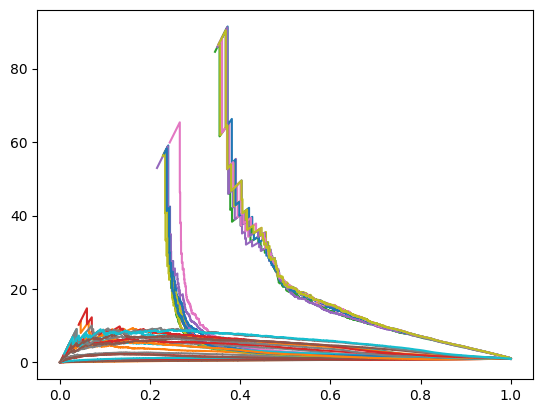

In [61]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)

initial_learning_rate = 0.05 #placeholder till callback

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
)

for sigfrac in np.logspace(-3,-1,20):
    print(w1, w2, sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all_BCE.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all_BCE(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1.+sigfrac*LLR-sigfrac
    #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    ws = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

    m1 = 2
    m2 = 5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    #signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]])
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]))])

    print(N,len(x[0,0])-N,len(x[m1,m2][0:int(sigfrac*N)]),len(x[m1,m2][0:int(sigfrac*N)])/N)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    #plt.plot(tpr2,tpr2/np.sqrt(fpr2))

    msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
    msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]
plt.title(f"m1 = {m1} m2 = {m2}")
plt.xlabel("Average TPR")
plt.ylabel("Average TPR/sqrt(avg_fpr)")

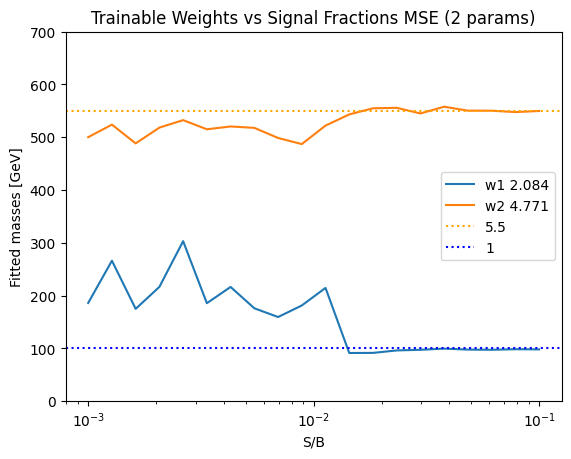

In [62]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

Text(0, 0.5, 'Max SIC')

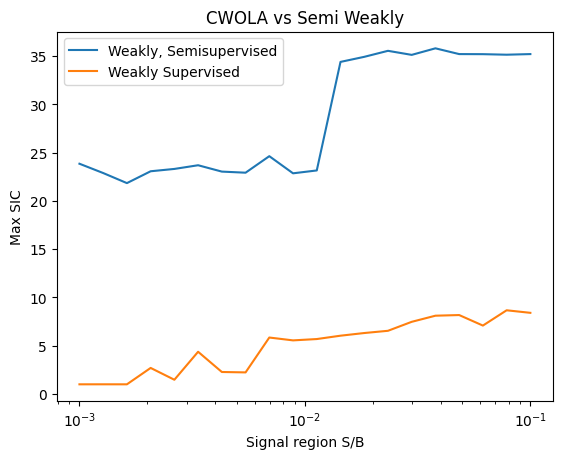

In [64]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")

3.913 5.542 0.001
30232 90698 30 0.0009923260121725325
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 669us/step
3.913 5.542 0.0012742749857031334
30232 90698 38 0.0012569462820852077
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 687us/step
3.913 5.542 0.001623776739188721
30232 90698 49 0.0016207991532151363
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 655us/step
3.913 5.542 0.00206913808111479
30232 90698 62 0.0020508070918232335
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 695us/step
3.913 5.542 0.0026366508987303583
30232 90698 79 0.002613125165387669
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 656us/step
3.913 5.542 0.003359818286283781
30232 90698 101 0.0033408309076475256
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 685us/step
3.913 5.542 0.004281332398719396
30232 90698 129 0.004267001852341889
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 646us/step
3.913 5.542 0.00545559478116852
30232 90698 164 0.0054247155332098436
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 690us/step
3.913 5.542 0.0069519279617756054
30232 90698 210 0.006946282085207727
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 719us/step
3.913 5.542 0.008858667904100823
30232 90698 267 0.008831701508335538
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 651us/step
3.913 5.542 0.011288378916846888
30232 90698 341 0.011279439005027786
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 623us/step
3.913 5.542 0.01438449888287663
30232 90698 434 0.014355649642762636
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 610us/step
3.913 5.542 0.018329807108324356
30232 90698 554 0.018324953691452765
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 704us/step
3.913 5.542 0.023357214690901212
30232 90698 706 0.023352738819793595
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 639us/step
3.913 5.542 0.029763514416313176
30232 90698 899 0.02973670283143689
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 682us/step
3.913 5.542 0.0379269019073225
30232 90698 1146 0.03790685366499074
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 651us/step
3.913 5.542 0.04832930238571752
30232 90698 1461 0.04832627679280233
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 674us/step
3.913 5.542 0.06158482110660261
30232 90698 1861 0.061557290288436095
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 697us/step
3.913 5.542 0.07847599703514611
30232 90698 2372 0.07845991002910822
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 721us/step
3.913 5.542 0.1
30232 90698 3023 0.09999338449325218
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 696us/step
0.541 2.11 0.001
30232 90698 30 0.0009923260121725325
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 633us/step
0.541 2.11 0.0012742749857031334
30232 90698 38 0.0012569462820852077
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 687us/step
0.541 2.11 0.001623776739188721
30232 90698 49 0.0016207991532151363
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 643us/step
0.541 2.11 0.00206913808111479
30232 90698 62 0.0020508070918232335
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 704us/step
0.541 2.11 0.0026366508987303583
30232 90698 79 0.002613125165387669
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 683us/step
0.541 2.11 0.003359818286283781
30232 90698 101 0.0033408309076475256
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 675us/step
0.541 2.11 0.004281332398719396
30232 90698 129 0.004267001852341889
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 626us/step
0.541 2.11 0.00545559478116852
30232 90698 164 0.0054247155332098436
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 687us/step
0.541 2.11 0.0069519279617756054
30232 90698 210 0.006946282085207727
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 673us/step
0.541 2.11 0.008858667904100823
30232 90698 267 0.008831701508335538
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 677us/step
0.541 2.11 0.011288378916846888
30232 90698 341 0.011279439005027786
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 719us/step
0.541 2.11 0.01438449888287663
30232 90698 434 0.014355649642762636
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 689us/step
0.541 2.11 0.018329807108324356
30232 90698 554 0.018324953691452765
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 676us/step
0.541 2.11 0.023357214690901212
30232 90698 706 0.023352738819793595
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 677us/step
0.541 2.11 0.029763514416313176
30232 90698 899 0.02973670283143689
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 637us/step
0.541 2.11 0.0379269019073225
30232 90698 1146 0.03790685366499074
93/93 [==============================] - 0s 2ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 754us/step
0.541 2.11 0.04832930238571752
30232 90698 1461 0.04832627679280233
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 677us/step
0.541 2.11 0.06158482110660261
30232 90698 1861 0.061557290288436095
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 640us/step
0.541 2.11 0.07847599703514611
30232 90698 2372 0.07845991002910822
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 646us/step
0.541 2.11 0.1
30232 90698 3023 0.09999338449325218
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 699us/step
1.951 5.277 0.001
30232 90698 30 0.0009923260121725325
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 689us/step
1.951 5.277 0.0012742749857031334
30232 90698 38 0.0012569462820852077
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 673us/step
1.951 5.277 0.001623776739188721
30232 90698 49 0.0016207991532151363
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 687us/step
1.951 5.277 0.00206913808111479
30232 90698 62 0.0020508070918232335
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 655us/step
1.951 5.277 0.0026366508987303583
30232 90698 79 0.002613125165387669
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 677us/step
1.951 5.277 0.003359818286283781
30232 90698 101 0.0033408309076475256
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 653us/step
1.951 5.277 0.004281332398719396
30232 90698 129 0.004267001852341889
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 690us/step
1.951 5.277 0.00545559478116852
30232 90698 164 0.0054247155332098436
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 675us/step
1.951 5.277 0.0069519279617756054
30232 90698 210 0.006946282085207727
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 655us/step
1.951 5.277 0.008858667904100823
30232 90698 267 0.008831701508335538
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 661us/step
1.951 5.277 0.011288378916846888
30232 90698 341 0.011279439005027786
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 684us/step
1.951 5.277 0.01438449888287663
30232 90698 434 0.014355649642762636
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 680us/step
1.951 5.277 0.018329807108324356
30232 90698 554 0.018324953691452765
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 681us/step
1.951 5.277 0.023357214690901212
30232 90698 706 0.023352738819793595
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 672us/step
1.951 5.277 0.029763514416313176
30232 90698 899 0.02973670283143689
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 689us/step
1.951 5.277 0.0379269019073225
30232 90698 1146 0.03790685366499074
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 691us/step
1.951 5.277 0.04832930238571752
30232 90698 1461 0.04832627679280233
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 680us/step
1.951 5.277 0.06158482110660261
30232 90698 1861 0.061557290288436095
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 656us/step
1.951 5.277 0.07847599703514611
30232 90698 2372 0.07845991002910822
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 648us/step
1.951 5.277 0.1
30232 90698 3023 0.09999338449325218
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 664us/step
4.131 0.854 0.001
30232 90698 30 0.0009923260121725325
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 654us/step
4.131 0.854 0.0012742749857031334
30232 90698 38 0.0012569462820852077
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 670us/step
4.131 0.854 0.001623776739188721
30232 90698 49 0.0016207991532151363
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 659us/step
4.131 0.854 0.00206913808111479
30232 90698 62 0.0020508070918232335
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 691us/step
4.131 0.854 0.0026366508987303583
30232 90698 79 0.002613125165387669
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 683us/step
4.131 0.854 0.003359818286283781
30232 90698 101 0.0033408309076475256
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 699us/step
4.131 0.854 0.004281332398719396
30232 90698 129 0.004267001852341889
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 661us/step
4.131 0.854 0.00545559478116852
30232 90698 164 0.0054247155332098436
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 4s 662us/step
4.131 0.854 0.0069519279617756054
30232 90698 210 0.006946282085207727
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 687us/step
4.131 0.854 0.008858667904100823
30232 90698 267 0.008831701508335538
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 678us/step
4.131 0.854 0.011288378916846888
30232 90698 341 0.011279439005027786
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 682us/step
4.131 0.854 0.01438449888287663
30232 90698 434 0.014355649642762636
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 676us/step
4.131 0.854 0.018329807108324356
30232 90698 554 0.018324953691452765
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 694us/step
4.131 0.854 0.023357214690901212
30232 90698 706 0.023352738819793595
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 709us/step
4.131 0.854 0.029763514416313176
30232 90698 899 0.02973670283143689
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 657us/step
4.131 0.854 0.0379269019073225
30232 90698 1146 0.03790685366499074
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 697us/step
4.131 0.854 0.04832930238571752
30232 90698 1461 0.04832627679280233
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 700us/step
4.131 0.854 0.06158482110660261
30232 90698 1861 0.061557290288436095
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 734us/step
4.131 0.854 0.07847599703514611
30232 90698 2372 0.07845991002910822
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 659us/step
4.131 0.854 0.1
30232 90698 3023 0.09999338449325218
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 663us/step
4.556 4.975 0.001
30232 90698 30 0.0009923260121725325
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 637us/step
4.556 4.975 0.0012742749857031334
30232 90698 38 0.0012569462820852077
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 665us/step
4.556 4.975 0.001623776739188721
30232 90698 49 0.0016207991532151363
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 678us/step
4.556 4.975 0.00206913808111479
30232 90698 62 0.0020508070918232335
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 694us/step
4.556 4.975 0.0026366508987303583
30232 90698 79 0.002613125165387669
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 671us/step
4.556 4.975 0.003359818286283781
30232 90698 101 0.0033408309076475256
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 664us/step
4.556 4.975 0.004281332398719396
30232 90698 129 0.004267001852341889
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 655us/step
4.556 4.975 0.00545559478116852
30232 90698 164 0.0054247155332098436
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 670us/step
4.556 4.975 0.0069519279617756054
30232 90698 210 0.006946282085207727
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 675us/step
4.556 4.975 0.008858667904100823
30232 90698 267 0.008831701508335538
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 693us/step
4.556 4.975 0.011288378916846888
30232 90698 341 0.011279439005027786
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 672us/step
4.556 4.975 0.01438449888287663
30232 90698 434 0.014355649642762636
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 684us/step
4.556 4.975 0.018329807108324356
30232 90698 554 0.018324953691452765
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 626us/step
4.556 4.975 0.023357214690901212
30232 90698 706 0.023352738819793595
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 694us/step
4.556 4.975 0.029763514416313176
30232 90698 899 0.02973670283143689
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 669us/step
4.556 4.975 0.0379269019073225
30232 90698 1146 0.03790685366499074
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 688us/step
4.556 4.975 0.04832930238571752
30232 90698 1461 0.04832627679280233
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 686us/step
4.556 4.975 0.06158482110660261
30232 90698 1861 0.061557290288436095
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 673us/step
4.556 4.975 0.07847599703514611
30232 90698 2372 0.07845991002910822
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 728us/step
4.556 4.975 0.1
30232 90698 3023 0.09999338449325218
93/93 [==============================] - 0s 1ms/step


/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/2091318106.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


93/93 [==============================] - 0s 639us/step


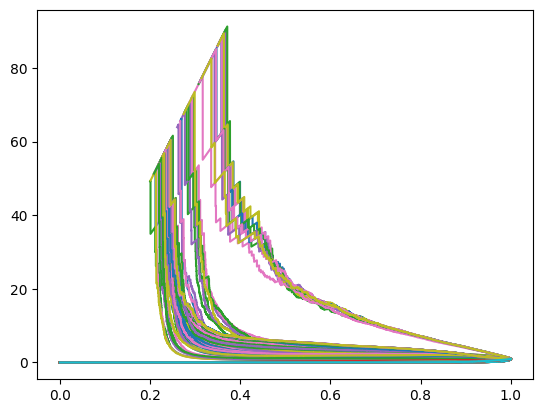

In [116]:
num_runs = 5
scores_list_runs = []

msic1_list_runs = []
msic2_list_runs = []

for _ in range(num_runs):

    xx = []
    yy = []
    zz = []
    ww = []

    msic1 = []
    msic2 = []
    
    score_list = []
    
    initial_learning_rate = 0.05 #placeholder till callback

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
    )

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    
    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05
        if (sigfrac > 0.5):
            continue

        for l in model_all_BCE.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all_BCE(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        #LLR_xs = 1.+sigfrac*LLR-sigfrac
        LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
        ws = LLR_xs / (1.+LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

        m1 = 1
        m2 = 5.5

        test_background = int(1/2 *len(x[0,0]))
        train_background = int(1/4 * len(x[0,0]))
        train_data = int(1/4 * len(x[0,0]))
        train_reference = int(1/4 * len(x[0,0]))
        #signal
        test_signal_length = int(1/2*len(x[m1,m2]))
        N = int(1/4 * (len(x[0,0])))
        #signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

        x_vals_ = np.concatenate([x[0,0][test_background:],x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]])
        y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]))])

        #print(N,len(x[0,0])-N,len(x[m1,m2][0:int(sigfrac*N)]),len(x[m1,m2][0:int(sigfrac*N)])/N)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        xx+=[sigfrac]
        yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
        zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
        ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        plt.plot(tpr,tpr/np.sqrt(fpr))
        
        score_list.append(scores)

        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=4, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        plt.plot(tpr,fpr)
        #plt.plot(tpr2,tpr2/np.sqrt(fpr2))

        msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
        msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]
        
    msic1_list_runs.append(msic1)
    msic2_list_runs.append(msic2)
    scores_list_runs.append(score_list)

/tmp/ipykernel_2071371/3099817985.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/3099817985.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/3099817985.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/3099817985.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/3099817985.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/3099817985.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/3099817985.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/3099817985.py:

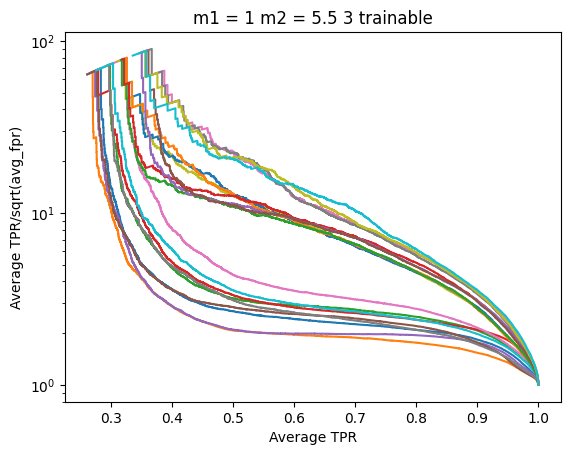

In [119]:
#epsilon = 1e-6
avg = np.mean(scores_list_runs, axis = 0)
for avg_scores in avg:
    avg_fpr, avg_tpr, _ = metrics.roc_curve(y, avg_scores)
    plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
    plt.title(f"m1 = {m1} m2 = {m2} 3 trainable")
    plt.xlabel("Average TPR")
    plt.ylabel("Average TPR/sqrt(avg_fpr)")
plt.yscale("log")

Text(0, 0.5, 'Avg Max SIC')

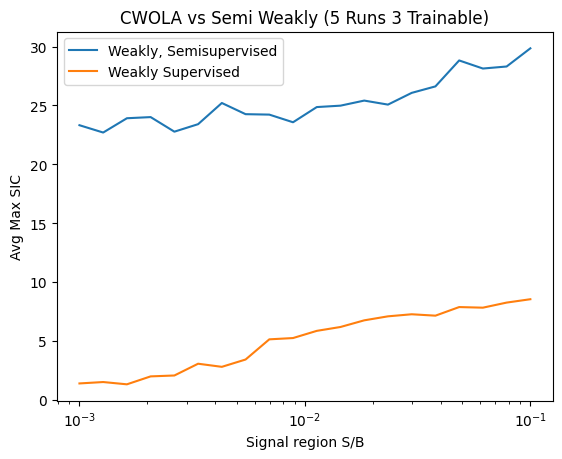

In [121]:
avgmsic1 = np.mean(msic1_list_runs, axis = 0)
avgmsic2 = np.mean(msic2_list_runs, axis = 0)

plt.plot(xx,avgmsic1,label="Weakly, Semisupervised")
plt.plot(xx,avgmsic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (5 Runs 3 Trainable)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

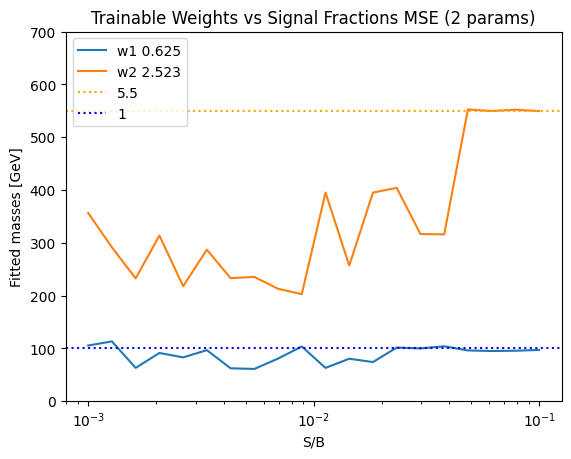

In [106]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

Text(0, 0.5, 'max SIC')

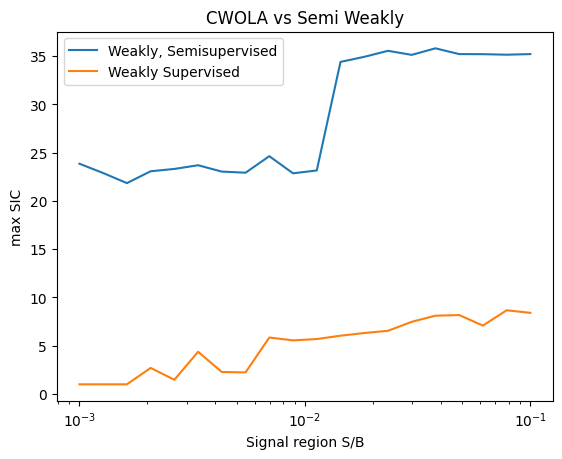

In [83]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Signal Fraction:  1e-05
Epoch 1/35
30/30 [==============================] - 1s 12ms/step - loss: 0.2501 - val_loss: 0.2501
Epoch 2/35
30/30 [==============================] - 1s 18ms/step - loss: 0.2501 - val_loss: 0.2501
Epoch 3/35
30/30 [==============================] - 0s 8ms/step - loss: 0.2501 - val_loss: 0.2501
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.2501 - val_loss: 0.2501
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.2501 - val_loss: 0.2501
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.2501 - val_loss: 0.2501
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.2501 - val_loss: 0.2501
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.2501 - val_loss: 0.2501
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.2501 - val_loss: 0.2501
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.2501 - val_loss: 

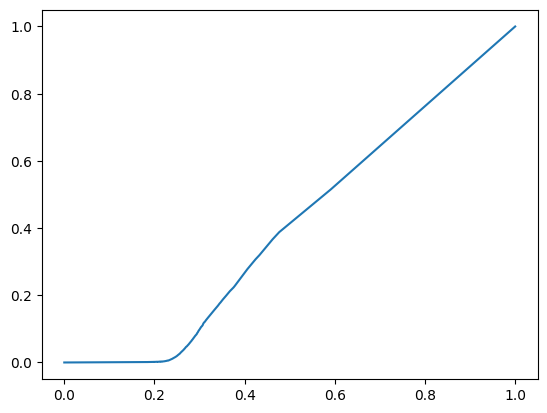

In [424]:
sigfrac = 1e-5
print("Signal Fraction: ", sigfrac)
for l in model_all_MSE.layers:
    l.trainable=False

w1 = 0.5
w2 = 0.5
model3 = createSimpleModel(w1)
model32 = createSimpleModel(w2)

inputs_hold3 = tf.keras.Input(shape=(1,))
simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

inputs = tf.keras.Input(shape=(4,))
inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_MSE(inputs2)
LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
LLR_xs = 1 + sigfrac * LLR - sigfrac
#LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
ws = (LLR_xs / (1.+ LLR_xs))
model_all2 = Model(inputs = inputs, outputs = ws)
model_all2.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

m1 = 1
m2 = 5.5

test_background = int(1/2 *len(x[0,0]))
train_background = int(1/4 * len(x[0,0]))
train_data = int(1/4 * len(x[0,0]))
train_reference = int(1/4 * len(x[0,0]))
#signal
test_signal_length = int(1/2*len(x[m1,m2]))
N = int(1/4 * (len(x[0,0])))
signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

x_vals_ = np.concatenate([x[0,0][test_background:],signal])
#[reference (0), data_background (1), signal(1)]
y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])

X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

sig_list+=[sigfrac]
w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
#w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
fpr, tpr, _ = metrics.roc_curve(y, scores)
#plt.plot(tpr,tpr/np.sqrt(fpr))
plt.plot(tpr,fpr)

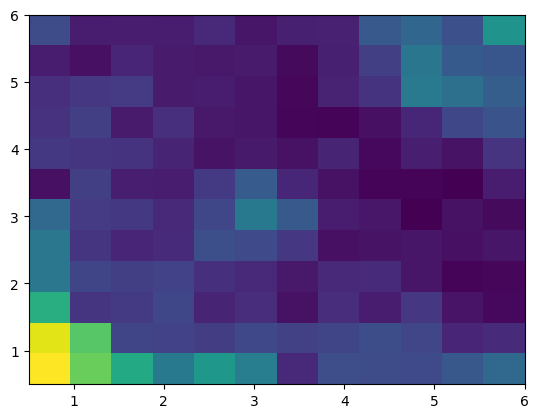

In [416]:
loss_values = list(z[sig_space[0], 1, 5.5])

plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=loss_values);

In [390]:
model_cwola.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14216 (Dense)         (None, 512)               2560      
                                                                 
 dense_14217 (Dense)         (None, 512)               262656    
                                                                 
 dense_14218 (Dense)         (None, 512)               262656    
                                                                 
 dense_14219 (Dense)         (None, 1)                 513       
                                                                 
Total params: 528,385
Trainable params: 528,385
Non-trainable params: 0
_________________________________________________________________


In [212]:
sigfrac = 0.03
signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

In [213]:
len(signal)

906

In [445]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

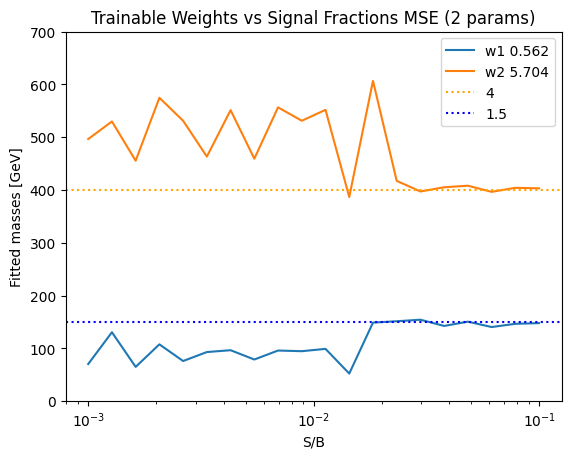

In [68]:
plt.plot(sig_list,np.array(w1_list)*100, label = f"w1 {w1}")
plt.plot(sig_list,np.array(w2_list)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

In [994]:
# plt.plot(sig_list,np.array(w3_list))
# plt.xscale("log")
# plt.yscale("log")
# plt.plot(sig_list,sig_list,ls=":",color="black")
# plt.xlabel("S/B")
# plt.ylabel("Fitted S/B")
# plt.title("S/B vs Fitted S/B")

Text(0, 0.5, 'max SIC')

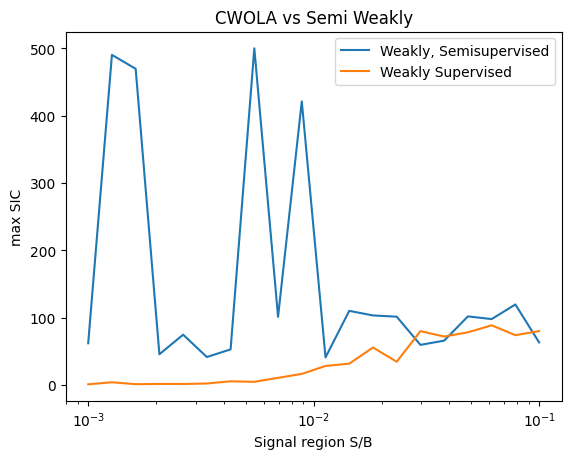

In [986]:
plt.plot(sig_list,max_SIC1,label="Weakly, Semisupervised")
plt.plot(sig_list,max_SIC2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

w1: 2.717 w2: 4.292
Signal Fraction:  0.001
30232 90698 30 0.0009923260121725325
2 4.5 1.8741326 4.521019
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0012742749857031334
30232 90698 38 0.0012569462820852077


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.7469313 4.7209115
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.001623776739188721
30232 90698 49 0.0016207991532151363


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.5154424 4.0403934
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00206913808111479
30232 90698 62 0.0020508070918232335


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.8873887 4.2762427
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0026366508987303583
30232 90698 79 0.002613125165387669


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.9109398 4.345872
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.003359818286283781
30232 90698 101 0.0033408309076475256


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.055745 4.6029882
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.004281332398719396
30232 90698 129 0.004267001852341889


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.8889372 4.704159
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00545559478116852
30232 90698 164 0.0054247155332098436


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.9197232 4.549439
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0069519279617756054
30232 90698 210 0.006946282085207727


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0110765 4.4997287
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.008858667904100823
30232 90698 267 0.008831701508335538


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.062847 4.3834352
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.011288378916846888
30232 90698 341 0.011279439005027786


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0241296 4.472058
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.01438449888287663
30232 90698 434 0.014355649642762636


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.98262 4.4804163
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.018329807108324356
30232 90698 554 0.018324953691452765


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0294394 4.486154
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.023357214690901212
30232 90698 706 0.023352738819793595


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.9934675 4.543621
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.029763514416313176
30232 90698 899 0.02973670283143689


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.987965 4.4381657
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0379269019073225
30232 90698 1146 0.03790685366499074


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.9904568 4.4825687
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.04832930238571752
30232 90698 1461 0.04832627679280233


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.981683 4.4782887
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.06158482110660261
30232 90698 1861 0.061557290288436095


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0121858 4.4617643
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.07847599703514611
30232 90698 2372 0.07845991002910822


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 1.9981275 4.484115
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.1
30232 90698 3023 0.09999338449325218


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0077946 4.527292
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
w1: 4.503 w2: 2.001
Signal Fraction:  0.001
30232 90698 30 0.0009923260121725325


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 5.085939 2.2402856
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0012742749857031334
30232 90698 38 0.0012569462820852077


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.404698 1.9405789
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.001623776739188721
30232 90698 49 0.0016207991532151363


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.242915 2.537829
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00206913808111479
30232 90698 62 0.0020508070918232335


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.6547685 1.8821589
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0026366508987303583
30232 90698 79 0.002613125165387669


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.365618 1.9172695
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.003359818286283781
30232 90698 101 0.0033408309076475256


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.559892 1.9136684
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.004281332398719396
30232 90698 129 0.004267001852341889


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5277414 1.9204527
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00545559478116852
30232 90698 164 0.0054247155332098436


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.6445746 2.0517197
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0069519279617756054
30232 90698 210 0.006946282085207727


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5829773 1.9194452
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.008858667904100823
30232 90698 267 0.008831701508335538


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.613103 1.9672025
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.011288378916846888
30232 90698 341 0.011279439005027786


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4080305 1.9160132
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.01438449888287663
30232 90698 434 0.014355649642762636


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.47644 2.0182106
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.018329807108324356
30232 90698 554 0.018324953691452765


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4825773 1.9454218
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.023357214690901212
30232 90698 706 0.023352738819793595


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.555824 2.0327148
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.029763514416313176
30232 90698 899 0.02973670283143689


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5380573 2.0320513
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0379269019073225
30232 90698 1146 0.03790685366499074


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.542685 2.0400105
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.04832930238571752
30232 90698 1461 0.04832627679280233


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.542856 1.9703215
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.06158482110660261
30232 90698 1861 0.061557290288436095


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4933505 2.0102987
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.07847599703514611
30232 90698 2372 0.07845991002910822


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5146527 1.9913999
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.1
30232 90698 3023 0.09999338449325218


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4971066 2.0272713
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
w1: 2.397 w2: 1.67
Signal Fraction:  0.001
30232 90698 30 0.0009923260121725325


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 3.2307875 2.112028
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0012742749857031334
30232 90698 38 0.0012569462820852077


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.78075 1.8491533
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.001623776739188721
30232 90698 49 0.0016207991532151363


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.465713 1.8568866
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00206913808111479
30232 90698 62 0.0020508070918232335


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0602891 1.6734134
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0026366508987303583
30232 90698 79 0.002613125165387669


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0592458 2.002693
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.003359818286283781
30232 90698 101 0.0033408309076475256


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.0864787 2.0753438
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.004281332398719396
30232 90698 129 0.004267001852341889


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.023057 2.1375756
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00545559478116852
30232 90698 164 0.0054247155332098436


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.7709553 1.8602544
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0069519279617756054
30232 90698 210 0.006946282085207727


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.393886 2.0829325
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.008858667904100823
30232 90698 267 0.008831701508335538


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 3.2798936 1.9550468
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.011288378916846888
30232 90698 341 0.011279439005027786


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.4378617 2.1324606
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.01438449888287663
30232 90698 434 0.014355649642762636


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.2606332 2.1971643
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.018329807108324356
30232 90698 554 0.018324953691452765


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4658875 1.9444513
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.023357214690901212
30232 90698 706 0.023352738819793595


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.564958 1.9579475
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.029763514416313176
30232 90698 899 0.02973670283143689


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0616994 2.1858273
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0379269019073225
30232 90698 1146 0.03790685366499074


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.1447277 2.1717017
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.04832930238571752
30232 90698 1461 0.04832627679280233


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0797038 1.5040728
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.06158482110660261
30232 90698 1861 0.061557290288436095


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5277896 2.022633
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.07847599703514611
30232 90698 2372 0.07845991002910822


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4810653 2.0164464
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.1
30232 90698 3023 0.09999338449325218


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5263195 2.0071876
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
w1: 4.806 w2: 2.016
Signal Fraction:  0.001
30232 90698 30 0.0009923260121725325


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.9197464 1.8766885
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0012742749857031334


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30232 90698 38 0.0012569462820852077
2 4.5 4.7554884 1.8917906
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.001623776739188721
30232 90698 49 0.0016207991532151363


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.688562 1.9204869
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00206913808111479
30232 90698 62 0.0020508070918232335


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.536598 1.9185649
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0026366508987303583
30232 90698 79 0.002613125165387669


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.6819897 2.060431
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.003359818286283781
30232 90698 101 0.0033408309076475256


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.473466 1.9613078
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.004281332398719396
30232 90698 129 0.004267001852341889


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.3869276 1.9211055
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00545559478116852
30232 90698 164 0.0054247155332098436


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4156227 2.036312
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0069519279617756054
30232 90698 210 0.006946282085207727


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.6854463 1.9500567
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.008858667904100823
30232 90698 267 0.008831701508335538


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5964894 1.9443434
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.011288378916846888
30232 90698 341 0.011279439005027786


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.618981 1.931767
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.01438449888287663
30232 90698 434 0.014355649642762636


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4014964 2.051446
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.018329807108324356
30232 90698 554 0.018324953691452765


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4722095 2.027935
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.023357214690901212
30232 90698 706 0.023352738819793595


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.468805 2.0669508
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.029763514416313176
30232 90698 899 0.02973670283143689


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.499662 2.0259461
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0379269019073225
30232 90698 1146 0.03790685366499074


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.541192 2.0216072
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.04832930238571752
30232 90698 1461 0.04832627679280233


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4721828 2.0317438
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.06158482110660261
30232 90698 1861 0.061557290288436095


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4807568 2.0115886
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.07847599703514611
30232 90698 2372 0.07845991002910822


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5332823 2.023098
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.1
30232 90698 3023 0.09999338449325218


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.4913707 2.0118754
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
w1: 2.574 w2: 0.888
Signal Fraction:  0.001


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


30232 90698 30 0.0009923260121725325
2 4.5 2.0469155 1.020789
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0012742749857031334
30232 90698 38 0.0012569462820852077


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.956787 0.52106756
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.001623776739188721
30232 90698 49 0.0016207991532151363


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.5894704 0.69460255
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00206913808111479
30232 90698 62 0.0020508070918232335


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.2063637 0.48922017
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0026366508987303583
30232 90698 79 0.002613125165387669


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.9375932 0.71569127
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.003359818286283781
30232 90698 101 0.0033408309076475256


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.3299706 0.34873372
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.004281332398719396
30232 90698 129 0.004267001852341889


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.513803 0.7636327
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.00545559478116852
30232 90698 164 0.0054247155332098436


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.9995167 1.5677615
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0069519279617756054
30232 90698 210 0.006946282085207727


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5537047 1.9219521
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.008858667904100823
30232 90698 267 0.008831701508335538


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.8928373 1.1157167
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.011288378916846888
30232 90698 341 0.011279439005027786


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0503197 0.42790887
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.01438449888287663
30232 90698 434 0.014355649642762636


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.75318 0.71104354
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.018329807108324356
30232 90698 554 0.018324953691452765


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.552409 1.9307184
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.023357214690901212
30232 90698 706 0.023352738819793595


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0299242 0.901447
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.029763514416313176
30232 90698 899 0.02973670283143689


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 3.58425 0.42863873
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.0379269019073225
30232 90698 1146 0.03790685366499074


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0619714 1.0521591
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.04832930238571752
30232 90698 1461 0.04832627679280233


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0594687 1.060776
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.06158482110660261
30232 90698 1861 0.061557290288436095


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 4.5206766 2.0252275
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.07847599703514611
30232 90698 2372 0.07845991002910822


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.0341244 2.2093267
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860
Signal Fraction:  0.1
30232 90698 3023 0.09999338449325218


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


2 4.5 2.3066313 2.0610144
95/95 [==============================] - 0s 1ms/step
Num Scores: 96860


/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_2071371/3479042049.py:85: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


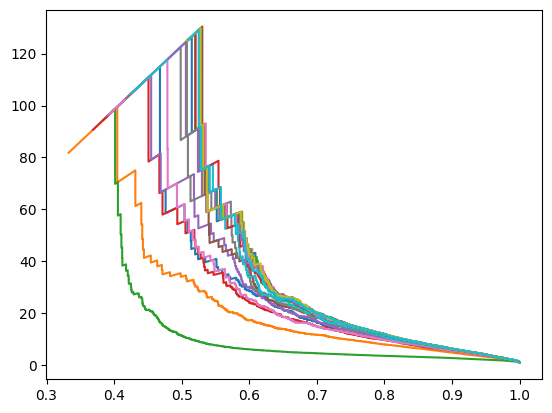

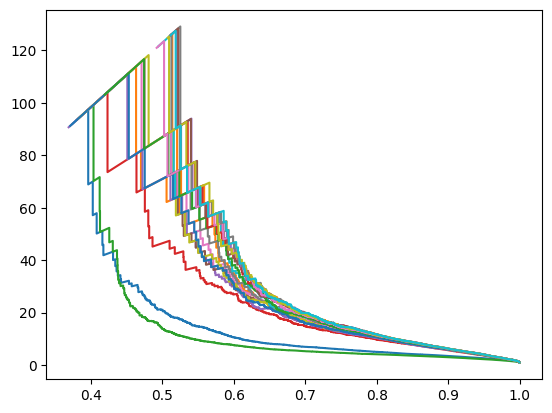

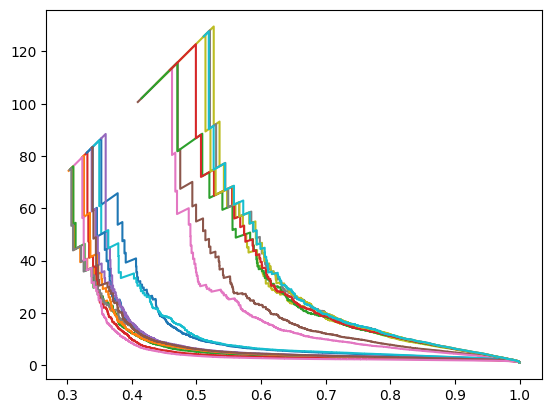

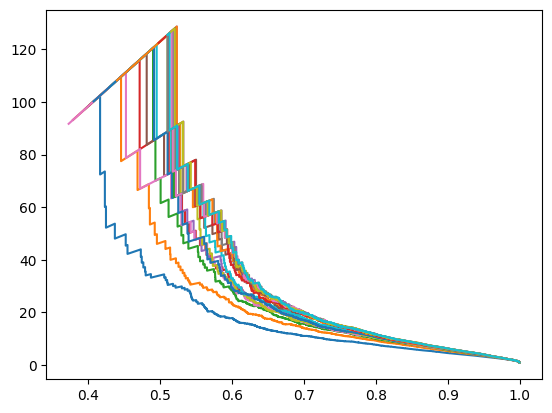

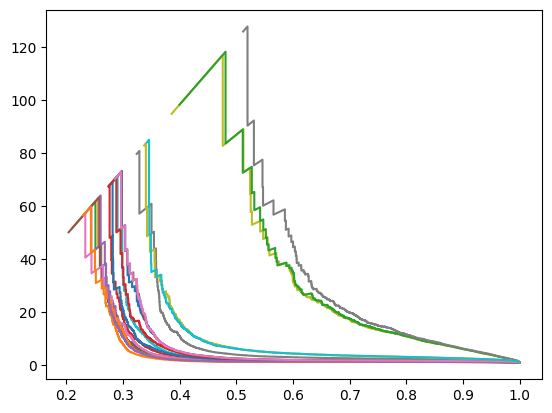

<Figure size 640x480 with 0 Axes>

In [25]:
num_runs = 5
scores_list_runs = []

w1_list_runs = []
w2_list_runs = []
for _ in range(num_runs):
    sig_list = []
    w1_list = []
    w2_list = []
    #w3_list = []

    #max_SIC1 = []
    #max_SIC2 = []

    scores_list = []

    #accuracies = []

    initial_learning_rate = 0.05
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
    )

    epsilon = 1e-6
    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    print(f"w1: {w1} w2: {w2}")
    sig_space = np.logspace(-3, -1, 20)
    for sigfrac in sig_space:
        #sigfrac = 0.01
        print("Signal Fraction: ", sigfrac)
        for l in model_all_BCE.layers:
            l.trainable=False

        #print(w1, w2)

        model3 = createSimpleModel(w1)
        model32 = createSimpleModel(w2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all_BCE(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1 + sigfrac*LLR - sigfrac
        #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0]) * LLR
        ws = LLR_xs / (1.+ LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

        m1 = 2.5
        m2 = 5

        test_background = int(1/2 *len(x[0,0]))
        train_background = int(1/4 * len(x[0,0]))
        train_data = int(1/4 * len(x[0,0]))
        train_reference = int(1/4 * len(x[0,0]))
        #signal
        test_signal_length = int(1/2*len(x[m1,m2]))
        N = int(1/4 * (len(x[0,0])))
        signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

        x_vals_ = np.concatenate([x[0,0][test_background:],signal])
        #[reference (0), data_background (1), signal(1)]
        y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(signal))])
        print(train_reference,len(x[0,0])-train_reference,len(x[m1,m2][0:int(sigfrac*train_reference)]),len(x[m1,m2][0:int(sigfrac*train_reference)])/train_reference)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

        sig_list+=[sigfrac]
        w1_list+=[model_all2.trainable_weights[0].numpy()[0][0]]
        w2_list+=[model_all2.trainable_weights[1].numpy()[0][0]]
        #w3_list+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]

        print(m1, m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

        scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        plt.plot(tpr,tpr/np.sqrt(fpr))

        scores_list.append(scores)
        print(f"Num Scores: {len(scores)}")
    scores_list_runs.append(scores_list)
    plt.figure()
    #plt.yscale("log")
        #accuracy_model = pred_accuracy(y, list(scores))

        #accuracies.append(accuracy_model)

In [370]:
np.shape(scores_list_runs)

(5, 20, 94793, 1)

In [141]:
#np.save("scores_list_runs.npy", scores_list_runs)

In [26]:
avg = np.mean(scores_list_runs, axis = 0)

In [388]:
np.shape(avg)

(20, 96560, 1)

In [332]:
# for sig in range(len(sig_space)):
#     avg_score_list.append((scores_list_runs[0][sig] + scores_list_runs[1][sig] + scores_list_runs[2][sig] + scores_list_runs[3][sig] + scores_list_runs[4][sig])/5)

/tmp/ipykernel_2071371/1374396933.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/1374396933.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/1374396933.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/1374396933.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/1374396933.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/1374396933.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/1374396933.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
/tmp/ipykernel_2071371/1374396933.py:

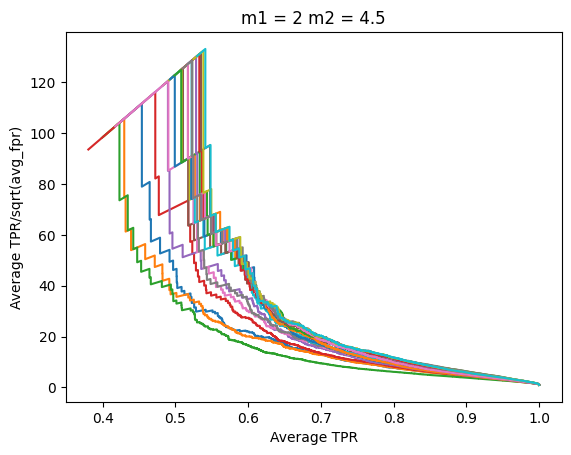

In [27]:
epsilon = 1e-6
avg = np.mean(scores_list_runs, axis = 0)
for avg_scores in avg:
    avg_fpr, avg_tpr, _ = metrics.roc_curve(y, avg_scores)
    plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
    plt.title(f"m1 = {m1} m2 = {m2}")
    plt.xlabel("Average TPR")
    plt.ylabel("Average TPR/sqrt(avg_fpr)")
plt.yscale("log")

In [264]:
def pred_accuracy(y_test, scores):
    background_count, signal_count = 0, 0

    predictions_list = []
    for pred in scores:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            signal_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            background_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

In [265]:
accuracy_model = pred_accuracy(y, list(avg_score))
accuracy_model

0.9636950261582764

Text(0, 0.5, 'Counts')

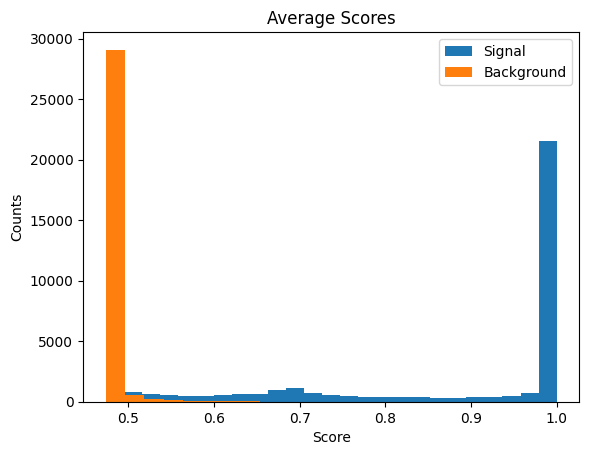

In [312]:
plt.hist(avg_scores[y==1], bins = 25, label = "Signal");
plt.hist(avg_scores[y==0], label = "Background");
plt.title("Average Scores")
plt.xlabel("Score")
plt.legend()
plt.ylabel("Counts")

(0.0, 700.0)

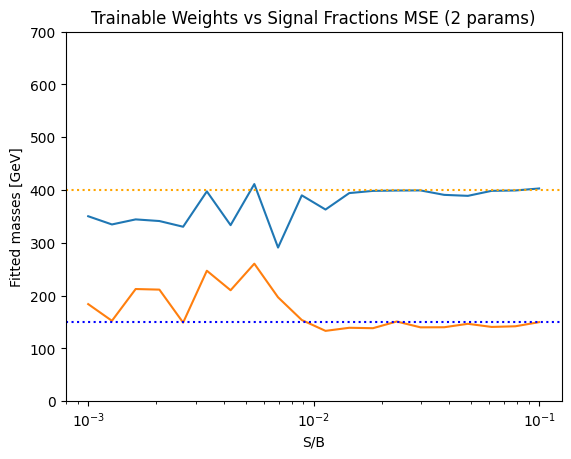

In [94]:
plt.plot(sig_list,np.array(w1_list)*100)
plt.plot(sig_list,np.array(w2_list)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

In [842]:
# plt.plot(sig_list,np.array(w3_list))
# plt.xscale("log")
# plt.yscale("log")
# plt.plot(sig_list,sig_list,ls=":",color="black")
# plt.xlabel("S/B")
# plt.ylabel("Fitted S/B")
# plt.title("S/B vs Fitted S/B")